# Full Python API example of ptdalgorithms
This notebook will describe almost all functions of the ptdalgorithms Python package. The core functionality is implemented in C, with a binding layer to Python through C++ and pybind11. Except for the specified construction code of the state space, most code will be almost equally fast to invoking the C api directly (maybe twice as slow). The package is based on graph algorithms published in (...), and is many orders of magnitude faster than matrix-based equations which are usually applied. We do not recommend using the C++ api directly.

We will show how to install the package and construct a state space through the Python api. We will then show how to compute the moments (expectation, variance) through the ptdalgorithms package, and how to compute the distribution functions. This means that you can make discrete and continuous phase-type distributions, compute their moments, distribution functions, sample from them, compute rewards and multivariate distributions, and time inhomogenous distributions.

We will also show how easy it is to create the state-space in C and return it to Python, to make large graphs!

In [1]:
%load_ext autoreload
%autoreload 2

## Installing the ptdalgorithms library

Using conda (recommended):

```txt
conda install -c conda-forge -c munch-group ptdalgorithms
```

Using pip:

```txt
pip install ptdalgorithms
```

In [2]:
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use('dark_background')
# import matplotlib
# matplotlib.rcParams['axes.facecolor'] = '#1F1F1F'
# matplotlib.rcParams['figure.facecolor'] = '#1F1F1F'


#%matplotlib widget

%config InlineBackend.figure_format = 'retina'

import ptdalgorithms as ptd

# State-space construction

In [3]:
def c(*args):
    elem = []
    for arg in args:
        if hasattr(arg, '__len__') and len(arg) > 1:
            elem.extend(arg)
        else:
            elem.append(arg)
    return np.array(elem)

In [4]:
def print_states(vertex):
    print(vertex.state())
    for edge in vertex.edges():
        print(" ", edge.weight() , "->", edge.to().state())    

This phase-type distribution models the time until all rabits have died We can find the expectation, variance, moments

In [5]:
def construct_rabbit_graph(nr_rabbits, flood_left, flood_right):
    
    # we represent the vector as two integers, the number of 
    # rabbits on the left and right island
    state_vector_length = 2
    graph = ptd.Graph(state_vector_length)
    
    # the initial state is the only starting state, with probability 1
    initial_state = [nr_rabbits, 0]
    vertex = graph.find_or_create_vertex(initial_state)
    graph.starting_vertex().add_edge(vertex, 1)
    
    index = 1
    # iterate over all unvisited vertices
    while index < graph.vertices_length():
        vertex = graph.vertex_at(index)
        state = vertex.state()
        
        if state[0] > 0:
            # rabbit jump left to right
            child_state = [state[0] - 1, state[1] + 1]
            vertex.add_edge(
                graph.find_or_create_vertex(child_state),
                weight=1
            )
            # left island flooding
            child_state = [0, state[1]]
            vertex.add_edge(
                graph.find_or_create_vertex(child_state), 
                weight=flood_left
            )
        if state[1] > 0:   
            child_state = [state[0] + 1, state[1] - 1]
            vertex.add_edge(
                graph.find_or_create_vertex(child_state),
                weight=1
            )
            # right island flooding
            child_state = [state[0], 0]
            vertex.add_edge(
                graph.find_or_create_vertex(child_state), 
                weight=flood_right
            )
    
        index += 1
    return graph

In [6]:
graph = construct_rabbit_graph(2, 2, 4)        
graph.states()

array([[0, 0],
       [2, 0],
       [1, 1],
       [0, 0],
       [0, 2],
       [0, 1],
       [1, 0]], dtype=int32)

You can plot the graph for visual inspection:

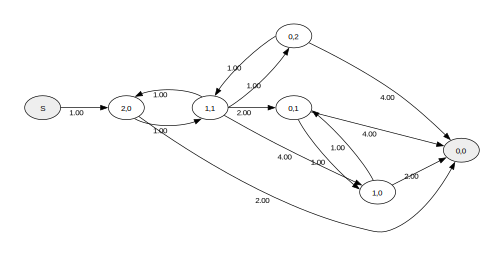

In [7]:
graph.plot()

and group, states by some property, by supplying a lambda function for the `subgraphfun` keyword argument:

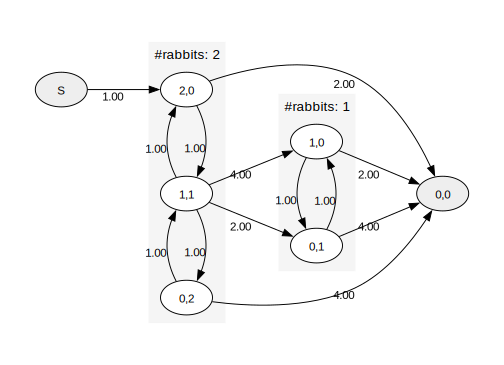

In [8]:
graph.plot(subgraphfun=lambda state: f"#rabbits: {sum(state)}")

In an abbreviated version using the aliases `ae` and `focv` for `add_edge` and `find_and_create_vertex`

In [9]:
nr_rabbits, flood_left, flood_right = 2, 2, 4

graph = ptd.Graph(2)
graph.starting_vertex().add_edge(graph.focv(c(nr_rabbits, 0)), 1)
i = 1
while i < graph.vertices_length():
    v = graph.vertex_at(i)
    st = v.state()
    if st[0] > 0:
        v.ae(graph.focv([st[0]-1, st[1]+1]), 1)
        v.ae(graph.focv([0, st[1]]), flood_left)
    if st[1] > 0:   
        v.ae(graph.focv([st[0]+1, st[1]-1]), 1)
        v.ae(graph.focv([st[0], 0]), flood_right)
    i += 1
    
#graph.states()

You can skip some of the boilerplate code by passing a callback function and an initial state to `Graph`. The call back function has the signature `callback(List[int]) -> List[Dict]`. It takes a list argument specifying a state and returns a list of dictionaries each specifying a child state and an edge weight: `{'state': [0, 1], 'weight': 0.4}`. This approach is slower and is intended mainly for speed up model development and exploration, and to reduce the amount of code needed to represent many models.

To create a callback function, just think of rules of your model and ask yourself: "Given some state, what are the allowed transitions to other states and with what rates to these transititons occur?". Make a small dictionary for each such transition with the child state and rate (weight) and return them as a list. Here is an example. If the current state is "two rabbits on the left island" (`[2, 0]`), the reachable states are: "one rabbit on each island" (`[1, 1]`) if one rabbit jumps and and "no rabbits" (`[0, 0]`) if the island is flodded. The callback function should in that case produce the mapping:

```python
[2, 0] -> [{'state': [1, 1], 'weight': 1, }, {'state': [0, 0], 'weight': flood_left}]
```

Here is what the callback function looks like for the rabbit model:

In [10]:
def rabbit_islands(state):
    children = []
    if state[0] > 0:
        children.append({'state': [state[0]-1, state[1]+1], 'weight': 1})
        children.append({'state': [0,          state[1]  ], 'weight': flood_left})
    if state[1] > 0:   
        children.append({'state': [state[0]+1, state[1]-1], 'weight': 1})
        children.append({'state': [state[0],   0         ], 'weight': flood_right})
    return children

initial_state = [nr_rabbits, 0]    

Notice that the usual scoping rules apply to the callback functions: the variables defined outside the function `flood_left` and `flood_right` are accessible to the function as for any Python function.

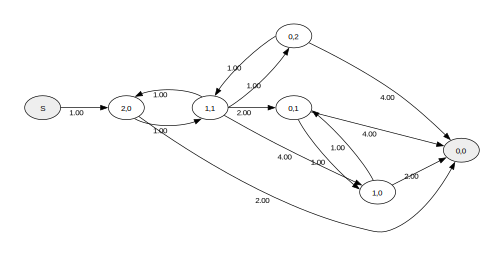

In [11]:
graph = ptd.Graph(callback=rabbit_islands,
                  initial=initial_state,
                  trans_as_dict=True)
graph.plot()

Notice `trans_as_dict=True` keyword argument above. To play more nicely with boradcasting this is `False` by default. Returning a list of (state, rate) tuples is the default callback signature:

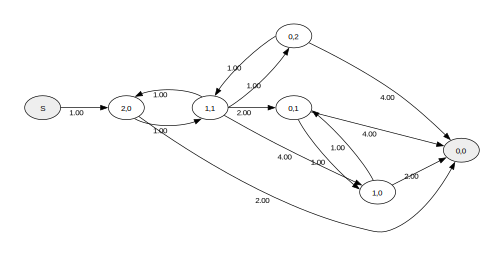

In [12]:
def rabbit_islands(state):
    children = []
    if state[0] > 0:
        children.append(([state[0]-1, state[1]+1], 1))
        children.append(([0,          state[1]  ], flood_left))
    if state[1] > 0:   
        children.append(([state[0]+1, state[1]-1], 1))
        children.append(([state[0],   0         ], flood_right))
    return children

initial_state = [nr_rabbits, 0]  

graph = ptd.Graph(callback=rabbit_islands,
                  initial=initial_state
                 )
graph.plot()

## Continuous phase-type distribution

We can now construct the graphs by the function. The flooding rates are set to 2 and 4

In [13]:
graph = construct_rabbit_graph(2, 2, 4)

Get the number of vertices in the graph:

In [14]:
graph.vertices_length()

7

as well as integer vector states that those vertices represent:

In [15]:
M = graph.states()
M

array([[0, 0],
       [2, 0],
       [1, 1],
       [0, 0],
       [0, 2],
       [0, 1],
       [1, 0]], dtype=int32)

(or nicely as a dataframe):

In [16]:
pd.DataFrame(M, columns=["Rabbits left", "Rabbits right"]).style.hide()

Rabbits left,Rabbits right
0,0
2,0
1,1
0,0
0,2
0,1
1,0


This phase-type distribution models the time until all rabits have died. For convenience, we can get its expectation and variance like this:

In [17]:
graph.expectation()

INFO: building reward compute graph...


0.5038265306122448

In [18]:
graph.variance()

0.2264567497917534

But if you want you can get any number of moments like this (here three):

In [19]:
graph.moments(3)

[0.5038265306122448, 0.48029792274052463, 0.6559101757731152]

We can find the expected waiting time given that we start in any of the states, not just the starting state:        

In [20]:
graph.expected_waiting_time()

[0.5038265306122448,
 0.5038265306122448,
 0.5114795918367346,
 0.0,
 0.30229591836734687,
 0.28571428571428564,
 0.4285714285714285]

If needed for downstream analysis, matrix-based representation of the phase-type distribution can be extracted. Note that the indices in this representatoin do *not* correspond to vertex indicies in the graph.

# this makes the kernel die...

In [21]:
# graph.as_matrices()

We can get the CDF and PDF. The distribution methods reuse cached computations and recompute only if the graph changes. Compare the running times for the first and second call to the function:

In [22]:
time = np.arange(0, 4, 0.001)

In [23]:
%%time
cdf = graph.cdf(time)

CPU times: user 309 μs, sys: 3 μs, total: 312 μs
Wall time: 315 μs


In [24]:
%%time
cdf = graph.cdf(time)

CPU times: user 34 μs, sys: 0 ns, total: 34 μs
Wall time: 35.8 μs


In [25]:
%%time
pdf = graph.pdf(time)

CPU times: user 32 μs, sys: 0 ns, total: 32 μs
Wall time: 34.1 μs


PDF and CDF of distribution. Observe the long tails!

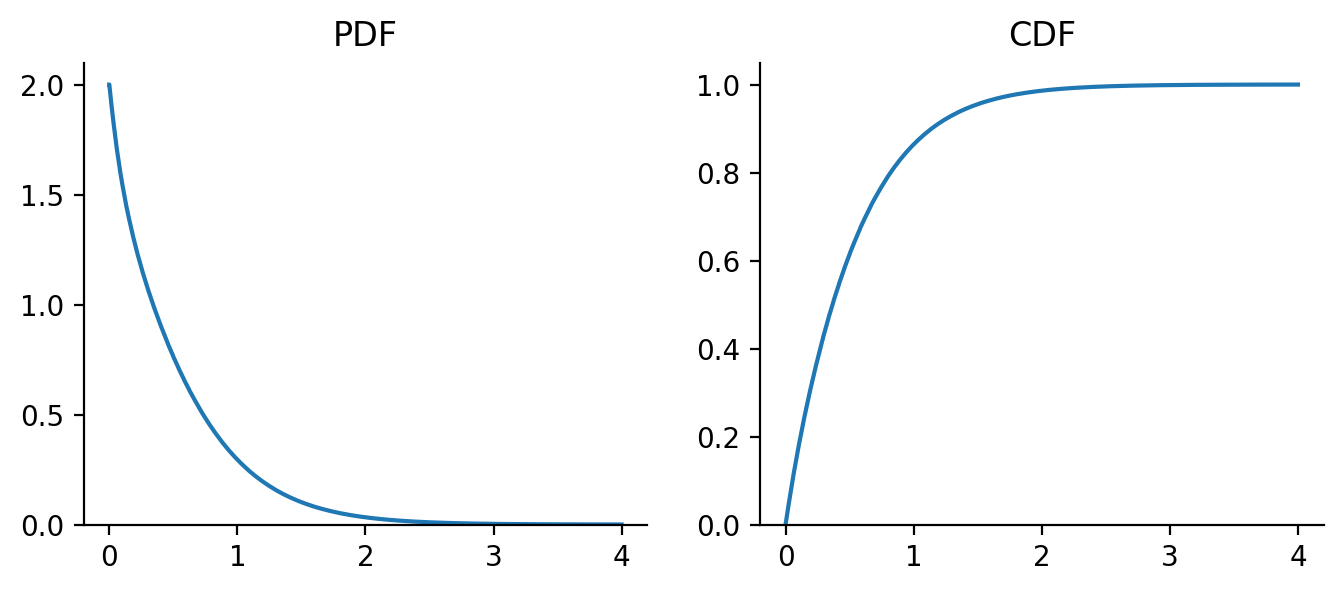

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.plot(time, pdf)
ax1.set_title("PDF")
ax1.set_ylim(bottom=0)
ax2.plot(time, cdf)
ax2.set_title("CDF")
ax2.set_ylim(bottom=0)
sns.despine()


## Rewards

We can add rewards which are based on the number of rabbits on the second island.

In [27]:
rewards = graph.states()[:, 1]

Can also be computed like this:

In [28]:
rewards = np.array([graph.vertex_at(i).state()[1] for i in range(graph.vertices_length())])

Adding these rewards, the phase-type distribution now represent the total accumulated time that any rabbits spends on the right island.

Using rewards to the moment functions etc. is much faster than changing the graph.

The expectation and variance are now:

In [29]:
graph.expectation(rewards), graph.variance(rewards)

(0.09438775510204081, 0.04634787588504789)

Using rewards to the moment functions etc. is much faster than actually changing the graph, but sometimes we might want to be interested in reward transforming the phase-type distribution, giving us the full distribution of accumulated rewards. For example if we want the pdf/cdf.

In [30]:
right_graph = graph.reward_transform(rewards)

Now we get the expectation and variance from before without adding any rewards:

In [31]:
right_graph.expectation(), right_graph.variance()

INFO: building reward compute graph...


(0.09438775510204081, 0.04634787588504791)

We can find the distribution function for the the total accumulate time spent by any rabbit on an island. We show here the PDF and CDF

In [32]:
accumulated_rewards = np.arange(0, 2, 0.01)

pdf = right_graph.pdf(accumulated_rewards)
cdf = right_graph.cdf(accumulated_rewards)

PDF and CDF of distribution. Notice how we have a "defect" i.e. a probability of obtaining no rewards:

In [33]:
right_graph.defect()

0.6666666666666666

The defect is shown with a dotted line below. Remember to always consider this defect.

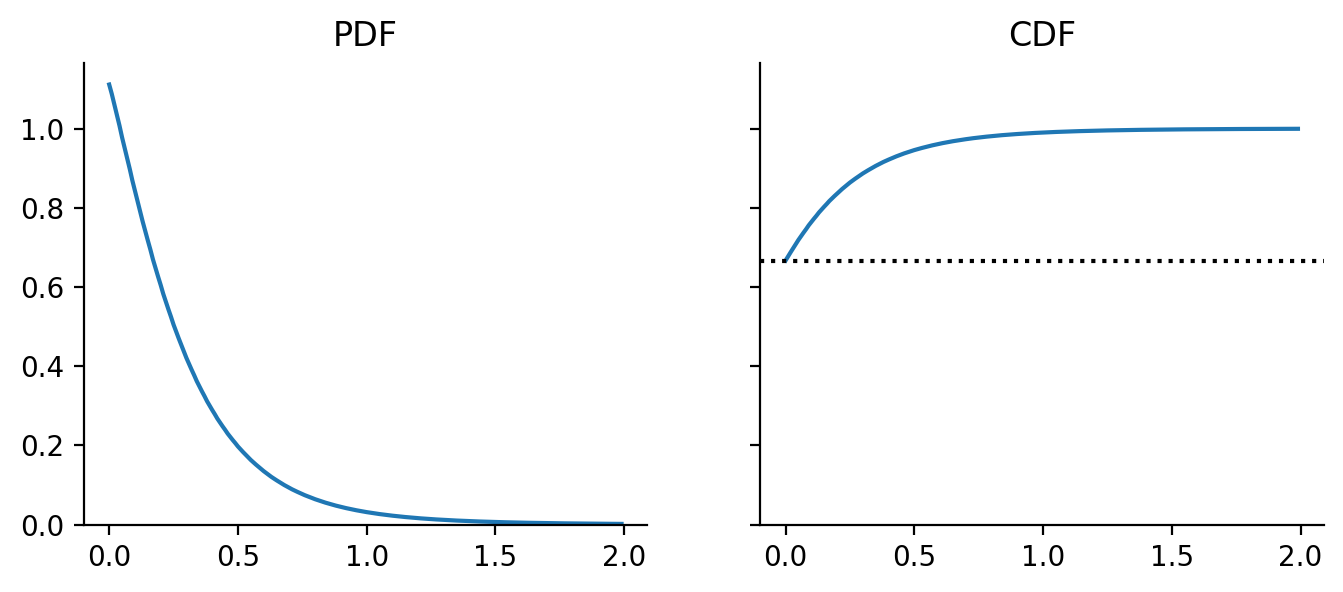

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
ax1.plot(accumulated_rewards, pdf)
ax1.set_title("PDF")
ax1.set_ylim(bottom=0)
ax2.plot(accumulated_rewards, cdf)
ax2.set_title("CDF")
ax2.set_ylim(bottom=0)
ax2.axhline(y=right_graph.defect(), linestyle='dotted', color='black')
sns.despine()

There are also utility methods to get the stop probability i.e. probabilities of occupying each state at time t. 

In [35]:
graph.stop_probability(0.2)

[0.0,
 0.5561531639166896,
 0.07040541534825098,
 0.0,
 0.007095725804629082,
 0.016348108066650276,
 0.03374890558205247]

We can use that to compute the expected number of rabbits across time:

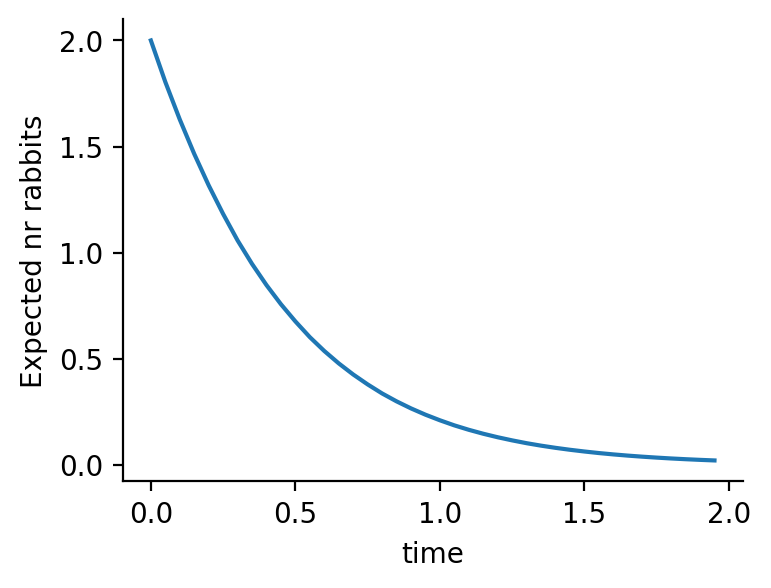

In [36]:
times = np.arange(0, 2, 0.05)
expected_rabbits_left = [
    np.sum(graph.stop_probability(i) 
           * np.sum(graph.states(), axis=1)) 
    for i in times
    ]

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(times, expected_rabbits_left)
ax.set_xlabel('time')
ax.set_ylabel("Expected nr rabbits")
sns.despine()


We can also get the accumulated visiting time of a particular state. E.g. the total time before time t=0.5 where there was a rabbit on the right island:

In [37]:
rewards = (graph.states()[:,1]>0).astype(int)
np.sum(graph.accumulated_visiting_time(time=0.5) * rewards)

np.float64(0.04053231796047568)

In [38]:
graph.expected_residence_time()

[0.0, 0.5038265306122448, 0.0, 0.0, 0.0, 0.0, 0.0]

# Random sampling

The library includes functions to do random sampling. These are useful to also validate the computations

In [39]:
graph.sample(5)

[0.30390544192090957,
 0.020477213998531155,
 0.13019196755993087,
 0.17178606952608544,
 0.4674379039508838]

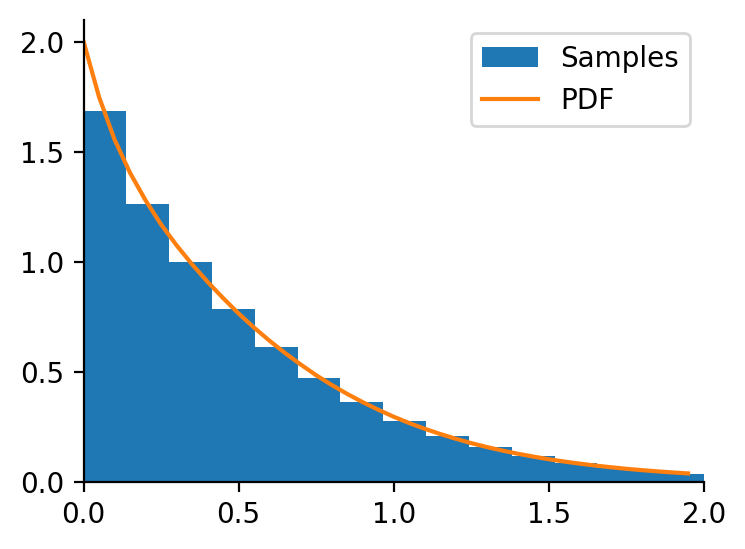

In [40]:
fig, ax = plt.subplots(figsize=(4, 3))
samples = graph.sample(1000000)

ax.hist(samples, bins=50, density=True, label='Samples')
x = np.arange(0, 2, 0.05)

ax.plot(x, [graph.pdf(t) for t in x], label='PDF')

ax.set_xlim(0, 2)
ax.legend()
sns.despine()

You can produce the moments from sampling if needed. Compare to the sampled and exact second moments:

In [41]:
np.sum(np.array(graph.sample(1000000))**2)/1000000, graph.moments(2)[1]

(np.float64(0.48061225409880987), 0.48029792274052463)

In [42]:
rewards = graph.states()[:,1]
np.sum(np.array(graph.sample(1000000, rewards))**2)/1000000, graph.moments(2, rewards)[1]

(np.float64(0.05488849178063228), 0.05525692419825073)

Reward-transforming first and then computing without rewards achieves the same thing:

In [43]:
revtr_graph = graph.reward_transform(rewards)
np.sum(np.array(revtr_graph.sample(1000000))**2)/1000000, revtr_graph.moments(2)[1]

INFO: building reward compute graph...


(np.float64(0.05522018538977551), 0.055256924198250734)

## Discrete phase-type distributions

We can also work with discrete phase-type distributions. This is the number of jumps in a Markov Chain before absorption. We will model that any rabbit can find a carrot at each time with rate 0.1 and see how many carrots the rabbits will have found. We could of course just make a new state-space creation function, but we can also manipulate existing.

In [44]:
carrot_graph = graph.clone()
vlength = carrot_graph.vertices_length()
carrot_vertices = np.repeat(False, vlength*2)


for i in range(vlength):
    vertex = carrot_graph.vertex_at(i)
    rabbits = sum(vertex.state())
    
    if rabbits > 0:
        obtained_carrot_vertex = carrot_graph.create_vertex([0])
        # Go directly back to the state we came from
        obtained_carrot_vertex.add_edge(vertex, 1)
        # Rate of finding carrot
        vertex.add_edge(obtained_carrot_vertex, rabbits * 0.1)
        carrot_vertices[obtained_carrot_vertex.index()] = True


In [45]:



vlength = carrot_graph.vertices_length()
carrot_vertices = np.repeat(False, vlength*2)

for i in range(vlength):
    vertex = carrot_graph.vertex_at(i)
    rabbits = sum(vertex.state())
    
    if rabbits > 0:
        obtained_carrot_vertex = carrot_graph.create_vertex([0])
        # Go directly back to the state we came from
        obtained_carrot_vertex.add_edge(vertex, 1)
        # Rate of finding carrot
        vertex.add_edge(obtained_carrot_vertex, rabbits * 0.1)
        carrot_vertices[obtained_carrot_vertex.index()] = True

carrot_vertices = carrot_vertices[np.arange(carrot_graph.vertices_length())]

# We now want to make the graph discrete. We do this by 'normalizing' the edges
# This is imply scaling the vertices such that the total out-going rate is 1
# As it is now the probability of transitions
weights_were_multiplied_with = carrot_graph.normalize()

print("This is the discrete state space as a sub-transition matrix:")
#carrot_graph.as_matrices()

This is the discrete state space as a sub-transition matrix:


In [46]:
for vertex in carrot_graph.vertices():
    print(vertex.index(),vertex.state(), vertex.edges())

0 [0, 0] [1-(2,0)]
1 [2, 0] [0.294118-(1,1), 0.588235-(0,0), 0.0588235-(0,0), 0.0588235-(0,0)]
2 [1, 1] [0.119048-(0,2), 0.238095-(0,1), 0.119048-(2,0), 0.47619-(1,0), 0.0238095-(0,0), 0.0238095-(0,0)]
3 [0, 0] []
4 [0, 2] [0.185185-(1,1), 0.740741-(0,0), 0.037037-(0,0), 0.037037-(0,0)]
5 [0, 1] [0.192308-(1,0), 0.769231-(0,0), 0.0192308-(0,0), 0.0192308-(0,0)]
6 [1, 0] [0.3125-(0,1), 0.625-(0,0), 0.03125-(0,0), 0.03125-(0,0)]
7 [0, 0] [1-(2,0)]
8 [0, 0] [1-(1,1)]
9 [0, 0] [1-(0,2)]
10 [0, 0] [1-(0,1)]
11 [0, 0] [1-(1,0)]
12 [0, 0] [1-(2,0)]
13 [0, 0] [1-(1,1)]
14 [0, 0] [1-(0,2)]
15 [0, 0] [1-(0,1)]
16 [0, 0] [1-(1,0)]


In [47]:
for vertex in carrot_graph.vertices():
    print(vertex)
    for edge in vertex.edges():
        print("  ", edge)

(0,0)
   1-(2,0)
(2,0)
   0.294118-(1,1)
   0.588235-(0,0)
   0.0588235-(0,0)
   0.0588235-(0,0)
(1,1)
   0.119048-(0,2)
   0.238095-(0,1)
   0.119048-(2,0)
   0.47619-(1,0)
   0.0238095-(0,0)
   0.0238095-(0,0)
(0,0)
(0,2)
   0.185185-(1,1)
   0.740741-(0,0)
   0.037037-(0,0)
   0.037037-(0,0)
(0,1)
   0.192308-(1,0)
   0.769231-(0,0)
   0.0192308-(0,0)
   0.0192308-(0,0)
(1,0)
   0.3125-(0,1)
   0.625-(0,0)
   0.03125-(0,0)
   0.03125-(0,0)
(0,0)
   1-(2,0)
(0,0)
   1-(1,1)
(0,0)
   1-(0,2)
(0,0)
   1-(0,1)
(0,0)
   1-(1,0)
(0,0)
   1-(2,0)
(0,0)
   1-(1,1)
(0,0)
   1-(0,2)
(0,0)
   1-(0,1)
(0,0)
   1-(1,0)


In [48]:
carrot_vertices.astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

We now want to find the expected number of eaten carrots. We set the reward such that the carrot vertex has a reward of '1'.


In [49]:
rewards = carrot_vertices.astype(int)
carrot_graph.expectation_discrete(rewards)


INFO: building reward compute graph...


0.09056122448979592

We can verify that the number of carrots correspond to scaling the continuous graph:

In [50]:
graph.expectation(graph.states().sum(axis=1)) * 0.1

0.09056122448979591

Of course we cannot do this for other moments:

In [51]:
carrot_graph.variance_discrete(rewards)

0.09723142700957937

Verified by sampling:

In [52]:
samples = carrot_graph.sample_discrete(1000000, rewards)
samples = np.array(samples)
np.sum(samples**2) / 1000000 - ((np.sum(samples)) / 1000000)**2

np.float64(0.097734344375)

In [53]:
# We can find the distribution function for the the total number of carrots found
carrots = np.arange(10)
# Notice that with this reward transformation the graph is no longer sparse, as all paths through
# the graph are represented!!
found_carrots_graph  = carrot_graph.reward_transform_discrete(rewards)
pmf = found_carrots_graph.pmf_discrete(carrots)
cdf = found_carrots_graph.cdf_discrete(carrots)


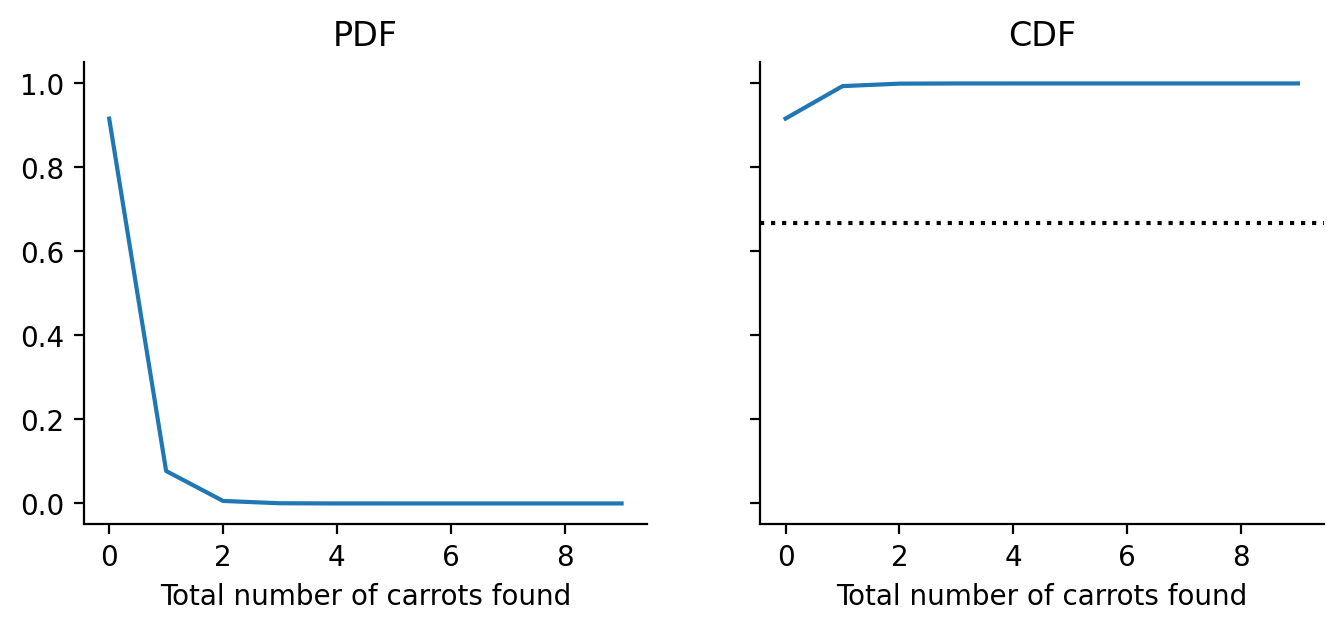

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
x = np.arange(0, 10, 1)
ax1.plot(x, pmf)
ax1.set_title("PDF")
ax1.set_xlabel('Total number of carrots found')
# ax1.set_ylim(bottom=0)
ax2.plot(x, cdf)
ax2.set_title("CDF")
# ax2.set_ylim(bottom=0)
ax2.set_xlabel('Total number of carrots found')
ax2.axhline(y=right_graph.defect(), linestyle='dotted', color='black')
sns.despine()

# Multivariate phase-type distributions

Instead of a univariate reward, we can have the distribution earn a 
*vector* of rewards for each time unit spent at a vertex.
We will continue with the rabbit example. We will now show the relationship
between total time spent by any rabbit on either of the two islands.

In [55]:
states = graph.states()
states[:, 1]

array([0, 0, 1, 0, 2, 1, 0], dtype=int32)

In [56]:
states = graph.states()
graph.covariance(states[:,0], states[:,1])

0.030003774468971296

In [57]:

simulations = graph.sample_multivariate(100000, graph.states())
simulated_cov = sum(simulations[0,:]*simulations[1,:])/100000 - \
                    sum(simulations[0,:])/100000*sum(simulations[1,:])/100000
simulated_cov

np.float64(0.030695764915293106)

The api also supports multivariate *discrete* phase-type distributions. We show the covariance between carrots found on either island.

In [58]:

mdph_carrot_graph = graph.clone()

vlength = mdph_carrot_graph.vertices_length()
carrot_vertices_left = np.repeat(False, vlength*2)
carrot_vertices_right = np.repeat(False, vlength*2)


for i in range(vlength):
    vertex = mdph_carrot_graph.vertex_at(i)
    rabbits = vertex.state()
    
    if rabbits[0] > 0:
        obtained_carrot_vertex = mdph_carrot_graph.create_vertex([0])
        # Go directly back to the state we came from
        obtained_carrot_vertex.add_edge(vertex, 1)
        # Rate of finding carrot
        vertex.add_edge(obtained_carrot_vertex, rabbits[0] * 0.1)
        carrot_vertices_left[obtained_carrot_vertex.index()] = True
    
    if rabbits[1] > 0:
        obtained_carrot_vertex = mdph_carrot_graph.create_vertex([0])
        # Go directly back to the state we came from
        obtained_carrot_vertex.add_edge(vertex, 1)
        # Rate of finding carrot
        vertex.add_edge(obtained_carrot_vertex, rabbits[1] * 0.1)
        carrot_vertices_right[obtained_carrot_vertex.index()] = True


Covariance:

In [59]:

carrot_vertices_left = carrot_vertices_left[0:mdph_carrot_graph.vertices_length()]
carrot_vertices_right = carrot_vertices_right[0:mdph_carrot_graph.vertices_length()]
mdph_carrot_graph.normalize()
rewards = np.column_stack((carrot_vertices_left, carrot_vertices_right)).astype(int)
mdph_carrot_graph.covariance_discrete(rewards[:,0], rewards[:,1])


INFO: building reward compute graph...


-0.0005338270512286547

Sampled covariance:

In [60]:

simulations = mdph_carrot_graph.sample_multivariate_discrete(1000000, rewards)
simulated_cov <- np.sum(simulations[0,:]*simulations[1,:])/1000000 - \
                    np.sum(simulations[0,:])/1000000*np.sum(simulations[1,:])/1000000
simulated_cov

np.float64(0.030695764915293106)

## Parameterized edges

We can *parameterize* the edges to easily update the weights of the edge

We do this by assigning a *state* to the *edge*.

We will now also say that the rate of rabbits jumping is proportional to the
number of rabbits on the island.

Our state is [rabbits able to jump, left flooding, right flooding]


In [61]:

def construct_rabbit_graph_params(nr_rabbits):
    # We represent the vector as two integers, the number of rabbits on the left and right island
    state_vector_length = 2
    graph = ptd.Graph(state_vector_length)
    initial_state = [nr_rabbits, 0]
    # The initial state is the only starting state, with 100% starting probability
    graph.starting_vertex().add_edge(
      graph.find_or_create_vertex(initial_state),
      1
    )
    index = 1
    # Iterate over all unvisited vertices
    while index < graph.vertices_length():
      vertex = graph.vertex_at(index)
      state = vertex.state()
      if state[0] > 0:
        # Rabbit jump left to right
        child_state = [state[0] - 1, state[1] + 1]
        vertex.add_edge_parameterized(
          graph.find_or_create_vertex(child_state),
          0,
          [state[0],0,0]
        )
        # Left island flooding
        child_state = c(0, state[1])
        vertex.add_edge_parameterized(
          graph.find_or_create_vertex(child_state),
          0,
          [0,1,0]
        )
      if state[1] > 0:
        # Rabbit jump right to left
        child_state = [state[0] + 1, state[1] - 1]
        vertex.add_edge_parameterized(
          graph.find_or_create_vertex(child_state),
          0, 
          [state[1],0,0]
        )
        # Right island flooding with rate of 4
        child_state = [state[0], 0]
        vertex.add_edge_parameterized(
          graph.find_or_create_vertex(child_state),
          0,
          [0,0,1]
        )
      index = index + 1

    return(graph)

The parameterized edges have what ever weight is assigned to them,
and the state does not by itself mean anything.

In [62]:
param_graph = construct_rabbit_graph_params(2)


If we let the edge have a state, this gives us an easy way of changing the weights
based on some model parameters. In this case, it is the rate of jumping
left rate of flooding and right rate of flooding.

The update simply takes the inner product of the state vector and
the model parameters, e.g. if the state is x1, x2 and the parameters are p1, p2, then
the weight of the edge becomed x1*p1+x2*p2

In [63]:
param_graph.update_parameterized_weights([1, 2, 4])
print("Expectation (1,2,4):", param_graph.expectation())

param_graph.update_parameterized_weights([2, 2, 4])
print("Expectation (1,2,4):", param_graph.expectation())

param_graph.update_parameterized_weights([2, 4, 4])
print("Expectation (1,2,4):", param_graph.expectation())

param_graph.update_parameterized_weights([2, 4, 18])
print("Expectation (1,2,4):", param_graph.expectation())

param_graph.update_parameterized_weights([8, 4, 18])
print("Expectation (1,2,4):", param_graph.expectation())

Expectation (1,2,4): 0.5083056478405314
Expectation (1,2,4): 0.49565217391304334
Expectation (1,2,4): 0.30000000000000004
Expectation (1,2,4): 0.22709632268736477
Expectation (1,2,4): 0.17719439369563442


INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...
INFO: building reward compute graph...


Note that the moment graph *has* to be recalculated after updating weights

In [64]:
param_graph.update_parameterized_weights([1, 2, 4])
#param_graph.as_matrices()
      
param_graph.update_parameterized_weights([8, 4, 18])
#param_graph.as_matrices()

## Time inhomogeneity

If the weights change over time - or new edges are added!

Then the distribution is time inhomogeneous. The api also
supports such distributions, but in limited manner.

Like the pph, dph, etc. functions, it is a (very good) approximation based
on very small steps. If the rates change dramatically, set the granularity
as an argument to the functions!! E.g. set it to a high enough value.

If we pick a time far into the future, we can integrate under the pdf to find the expectation!

Integrating over accumulated visiting time:

In [65]:
sum(graph.accumulated_visiting_time(10))

0.5038265306014538

The first moment (expectation):

In [66]:
graph.expectation()

0.5038265306122448

Say at a certain point in time, the flooding starts!

In the beginning, there is *no* flooding

In [67]:
param_graph.update_parameterized_weights([1, 0, 0])


We can build a context to step over the distribution.
Weights can be freely changed and edges added in such a context


In [68]:
# import ptdalgorithms as ptd
# import numpy as np

# def c(*args):
#     elem = []
#     for arg in args:
#         if hasattr(arg, '__len__') and len(arg) > 1:
#             elem.extend(arg)
#         else:
#             elem.append(arg)
#     return np.array(elem)


# nr_rabbits, flood_left, flood_right = 2, 2, 4

# # we represent the vector as two integers, the number of 
# # rabbits on the left and right island
# state_vector_length = 2
# graph = ptd.Graph(state_vector_length)

# # the initial state is the only starting state, with probability 1
# initial_state = c(nr_rabbits, 0)
# vertex = graph.find_or_create_vertex(initial_state)
# graph.starting_vertex().add_edge(vertex, 1)

# index = 1
# # iterate over all unvisited vertices
# while index < graph.vertices_length():
#     vertex = graph.vertex_at(index)
#     state = vertex.state()
    
#     if state[0] > 0:
#         # rabbit jump left to right
#         child_state = c(state[0] - 1, state[1] + 1)
#         vertex.add_edge(
#             graph.find_or_create_vertex(child_state),
#             weight=1
#         )
#         # left island flooding
#         child_state = c(0, state[1])
#         vertex.add_edge(
#             graph.find_or_create_vertex(child_state), 
#             weight=flood_left
#         )
#     if state[1] > 0:   
#         child_state = c(state[0] + 1, state[1] - 1)
#         vertex.add_edge(
#             graph.find_or_create_vertex(child_state),
#             weight=1
#         )
#         # right island flooding
#         child_state = c(state[0], 0)
#         vertex.add_edge(
#             graph.find_or_create_vertex(child_state), 
#             weight=flood_right
#         )

#     index += 1
    
# # graph.plot(nodesep=1, ranksep=0.1)

In [69]:

# ctx = graph.distribution_context()
# cdfs = []
# times = []

# # while ctx.time() < 1.5:
# while ctx.cdf() < 0.999:

#     cdfs.append(ctx.cdf())
#     times.append(ctx.time())
#     param_graph.update_parameterized_weights(
#         [1,
#         ctx.time() - 1.5, 
#         2 * ctx.time() - 1.5
#         ]
#     )
#     ctx.step()

It increases by every time step. Time until all rabbits are dead. Flooding increases linearly after 1.5 time units:

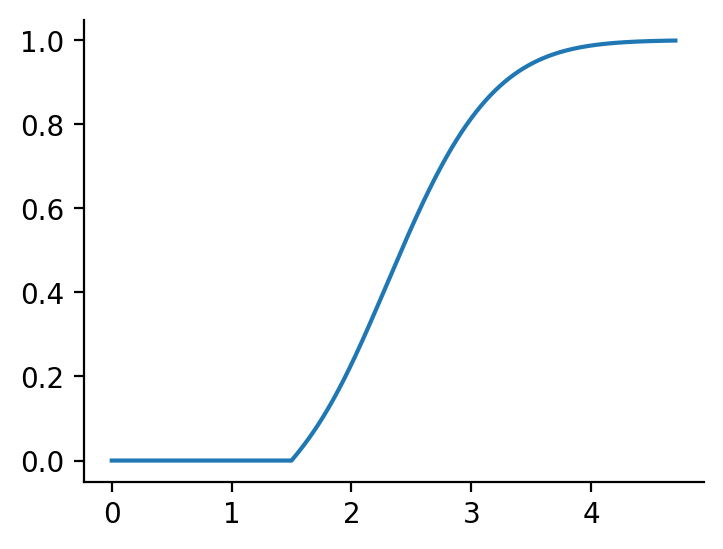

In [70]:
param_graph.update_parameterized_weights([1, 0, 0])

ctx = param_graph.distribution_context()
cdfs = []
times = []

while ctx.time() < 1.5:
    cdfs.append(ctx.cdf())
    times.append(ctx.time())
    ctx.step()

#param_graph.update_parameterized_weights([1, 1, 1])

# at time 1.5, the flooding starts!
while ctx.cdf() < 0.999:
    cdfs.append(ctx.cdf())
    times.append(ctx.time())
    param_graph.update_parameterized_weights(
        [1,
        ctx.time() - 1.5, 
        2 * ctx.time() - 1.5
        ]
    )
    ctx.step()

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(times, cdfs)
sns.despine()

If we pick a time far into the future, we can integrate under it to find the expectation. This means that we can scale by a reward, and thereby find the marginal expectation.

Summing over accumulated visiting time (with reward):

In [71]:
np.sum(graph.accumulated_visiting_time(10)*graph.states()[:,1])

np.float64(0.09438775509887067)

The first moment (expectation) (with reward):

In [72]:
graph.expectation(graph.states()[:,1])

0.09438775510204081

But if the time is *not* far into the future, we get the expectation up to a certain point in time.

Expectation (rewarded) when truncating at 0.05 time:          

In [73]:
np.sum(graph.accumulated_visiting_time(0.05)*graph.states()[:,1])

np.float64(0.0011713234985744549)

Untruncated expectation:

In [74]:
graph.expectation(graph.states()[:,1])

0.09438775510204081

Expectation (rewarded) when *starting* at 0.05 time:          

In [75]:
graph.expected_waiting_time(graph.states()[:,1])

[0.09438775510204081,
 0.09438775510204081,
 0.28316326530612246,
 0.0,
 0.4566326530612244,
 0.21428571428571422,
 0.0714285714285714]

In [76]:
np.sum(graph.stop_probability(0.05)*np.array(graph.expected_waiting_time(graph.states()[:,1])))

np.float64(0.09325811466426455)

Subtracting these gives the *same* value:          

In [77]:
(graph.expectation(graph.states()[:,1]) \
     - np.sum(graph.stop_probability(0.05) \
              * np.array(graph.expected_waiting_time(graph.states()[:,1])))
)

np.float64(0.0011296404377762609)

We can increase granularity for better performance:

In [78]:
np.sum(graph.accumulated_visiting_time(0.05, granularity=1000000)*graph.states()[:,1])

np.float64(0.0011138317897953385)

```c
// cppimport
#include <pybind11/pybind11.h>
#include <ptdalgorithms.h>

namespace py = pybind11;

using namespace pybind11::literals; // to bring in the `_a` literal

/* Basic C libraries */
#include "stdint.h"
#include "stdlib.h"

/* ----------------- Don't change the code above! ----------------- */


ptdalgorithms::Graph build(int starting_rabbits, float flooding_left, float flooding_right) {

    // using namespace ptdalgorithms;

    /* Same state size (left_rabbits, right_rabbits) */
    size_t state_size = 2;

    /* Create the graph structure */
    struct ptd_graph *graph = ptd_graph_create(state_size);

    /* We must crease the lookup tree as well! */
    struct ptd_avl_tree *avl_tree = ptd_avl_tree_create(state_size);

    /* Allocate the initial state, which means create an "array" of two values */
    int *initial_state = (int*)calloc(graph->state_length, sizeof(*initial_state));

    /* A "buffer" that allows us to manipulate the new child.
     * We need to 'free' this manually.
     */
    int *child_state = (int*)calloc(graph->state_length, sizeof(*initial_state));
    initial_state[0] = starting_rabbits;

    /* Add the starting edge, just like in the R api */
    ptd_graph_add_edge(
            graph->starting_vertex,
            ptd_find_or_create_vertex(graph, avl_tree, initial_state),
            1
    );

    /* Visit all vertices once */
    for (size_t k = 1; k < graph->vertices_length; k++) {
        struct ptd_vertex *vertex = graph->vertices[k];
        int *state = vertex->state;

        if (state[0] > 0) {
            // Rabbit jump left to right

            /* We use memcpy to copy the state into the child buffer!
             * As C or most other languages will *not* clone by default
             */
            memcpy(child_state, vertex->state, graph->state_length * sizeof(int));
            child_state[0] -= 1;
            child_state[1] += 1;

            /* ptd_find_or_create_vertex will *clone* the child_state
             * so no worries there!
             */
            ptd_graph_add_edge(
                    vertex,
                    ptd_find_or_create_vertex(graph, avl_tree, child_state),
                    1
            );

            memcpy(child_state, vertex->state, graph->state_length * sizeof(int));
            child_state[0] = 0;
            ptd_graph_add_edge(
                    vertex,
                    ptd_find_or_create_vertex(graph, avl_tree, child_state),
                    flooding_left
            );
        }

        if (state[1] > 0) {
            // Rabbit jump right to left
            memcpy(child_state, vertex->state, graph->state_length * sizeof(int));
            child_state[1] -= 1;
            child_state[0] += 1;
            ptd_graph_add_edge(
                    vertex,
                    ptd_find_or_create_vertex(graph, avl_tree, child_state),
                    1
            );

            memcpy(child_state, vertex->state, graph->state_length * sizeof(int));
            child_state[1] = 0;
            ptd_graph_add_edge(
                    vertex,
                    ptd_find_or_create_vertex(graph, avl_tree, child_state),
                    flooding_right
            );
        }
    }

    /* Manually free the allocated buffer memory */
    free(child_state);

    /*
     * This is the first time we use the C++ api to
     * bind the allocated graph to a C++ instance.
     * Only few methods should be used...
     * It has memory management by destructure, so no need
     * to manually free when done using.
     */
    ptdalgorithms::Graph *result = new ptdalgorithms::Graph(graph, avl_tree);

    /*
     * Use Rcpp to make this C++ instance visible to R. This is the
     * exact same type returned by `create_graph` in the R api,
     * which is why we need to make sure the cloned code is identical
     * to the currently installed R library (ptdalgorithms).
     */
    return *result;
}


/* NB: Change module name below to match the name of this file (without the suffix) */

PYBIND11_MODULE(rabbit_state_space, m) {

        m.def("build", &build);
}

/*
<%
setup_pybind11(cfg)
%>
*/
```

In [ ]:
import ptdalgorithms
import cppimport.import_hook
import rabbit_state_space #This will pause for a moment to compile the module
graph = ptdalgorithms.Graph(rabbit_state_space.build(2, 2, 4))
graph.plot()